### Principal Component Analysis
Many of the bands within hyperspectral images are often strongly correlated so we want to reduce the dimensionality of reflectance before we put it in the classification model. 

The principal components transformation represents a linear transformation of the original image bands to a set of new, uncorrelated features. These new features correspond to the eigenvectors of the image covariance matrix, where the associated eigenvalue represents the variance in the direction of the eigenvector. A very large percentage of the image variance can be captured in a relatively small number of principal components (compared to the original number of bands).

In [1]:
import sys
sys.version

'3.5.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:11:22) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [ ]:
#!{sys.executable} -m pip install '/Users/AuerPower/Downloads/pysptools-0.14.2.tar.gz'

In [2]:
import h5py, os, copy
import matplotlib.pyplot as plt
import numpy as np
import pysptools.util as util
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pysptools.classification as cls
import pysptools.material_count as cnt

from spectral import *
import spectral.io.envi as envi
import matplotlib.pyplot as plt
from matplotlib.mlab import PCA
import gdal

%matplotlib inline

#for clean output, to not print warnings, don't use when developing script
import warnings
warnings.filterwarnings('ignore')

In [3]:
def read_neon_reflh5(refl_filename):
    """read in a NEON AOP reflectance hdf5 file and returns 
    reflectance array, and metadata dictionary containing metadata 
    (similar to envi header format)
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata (all strings):
            bad_band_window1: min and max wavelenths of first water vapor window (tuple)
            bad_band_window2: min and max wavelenths of second water vapor window (tuple)
            bands: # of bands (float)
            coordinate system string: coordinate system information (string)
            data ignore value: value corresponding to no data (float)
            interleave: 'BSQ' (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
            spatial extent: extent of tile [xMin, xMax, yMin, yMax], UTM meters
    --------
    Example Execution:
    --------
    sercRefl, sercMetadata = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5') """

    #Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]

    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflData = refl['Reflectance_Data']
    reflArray = refl['Reflectance_Data'].value

    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    #Extract no data value & set no data value to NaN
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    metadata['interleave'] = reflData.attrs['Interleave']

    #Extract spatial extent from attributes
    metadata['spatial extent'] = reflData.attrs['Spatial_Extent_meters']

    #Extract bad band windows
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])

    #Extract projection information
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)

    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value

    hdf5_file.close        

    return reflArray, metadata

This function cleans the reflectance cube:
- removes the water vapor bands stored in the metadata as bad_band_window1 and bad_band_window2 
- removes the last 10 bands, which tend to be noisy.
- <s>sets -9999 to NAN</s>

In [16]:
def clean_neon_refl_data(data,metadata):
    """Clean h5 reflectance data and metadata
    1. set data ignore value (-9999) to NaN
    2. apply reflectance scale factor (10000)
    3. remove bad bands (water vapor band windows + last 10 bands): 
        Band_Window_1_Nanometers = 1340,1445
        Band_Window_2_Nanometers = 1790,1955
    """

    # use copy so original data and metadata doesn't change
    data_clean = data.copy().astype(float)
    metadata_clean = metadata.copy()

    #set data ignore value (-9999) to NaN:
    #if metadata['data ignore value'] in data:
    #    nodata_ind = np.where(data_clean==metadata['data ignore value'])
    #    data_clean[nodata_ind]=np.nan 

    #apply reflectance scale factor (divide by 10000)
    data_clean = data_clean/metadata['reflectance scale factor']

    #remove bad bands 
    #1. define indices corresponding to min/max center wavelength for each bad band window:
    bb1_ind0 = np.max(np.where((np.asarray(metadata['wavelength'])<float(metadata['bad_band_window1'][0]))))
    bb1_ind1 = np.min(np.where((np.asarray(metadata['wavelength'])>float(metadata['bad_band_window1'][1]))))

    bb2_ind0 = np.max(np.where((np.asarray(metadata['wavelength'])<float(metadata['bad_band_window2'][0]))))
    bb2_ind1 = np.min(np.where((np.asarray(metadata['wavelength'])>float(metadata['bad_band_window2'][1]))))

    bb3_ind0 = len(metadata['wavelength'])-10

    #define valid band ranges from indices:
    vb1 = list(range(0,bb1_ind0)); 
    vb2 = list(range(bb1_ind1,bb2_ind0))
    vb3 = list(range(bb2_ind1,bb3_ind0))

    valid_band_range = [i for j in (range(0,bb1_ind0),
                                    range(bb1_ind1,bb2_ind0),
                                    range(bb2_ind1,bb3_ind0)) for i in j]

    data_clean = data_clean[:,:,vb1+vb2+vb3]

    metadata_clean['wavelength'] = [metadata['wavelength'][i] for i in valid_band_range]

    return data_clean, metadata_clean

This function allows you to plot the cleaned data

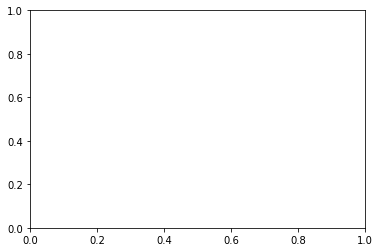

In [4]:
def plot_aop_refl(band_array,
                  refl_extent,
                  colorlimit=(0,1),
                  ax=plt.gca(),
                  title='',
                  cbar ='on',
                  cmap_title='',
                  colormap='Greys'):  
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); 

In [17]:
#refl,metadata = read_neon_reflh5('/Users/AuerPower/Google Drive/LaPHS/Hyperspectral/NEON_D01_HARV_DP3_732000_4703000_reflectance.h5')
refl,metadata = read_neon_reflh5('/Users/AuerPower/Documents/RSDI-2018/NEON-Tuesday-morning/data/NEON_D17_SJER_DP1_20180401_184649_reflectance.h5')

In [18]:
data_clean,metadata_clean = clean_neon_refl_data(refl,metadata)

In [19]:
print('Raw Data Dimensions:',refl.shape)
print('Cleaned Data Dimensions:',data_clean.shape)

Raw Data Dimensions: (216, 699, 426)
Cleaned Data Dimensions: (216, 699, 360)


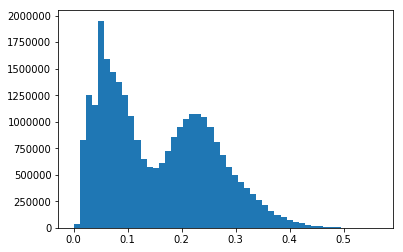

In [20]:
#plt.hist(data_clean[~np.isnan(data_clean)],50);
plt.hist(data_clean[data_clean!=-.9999],50);

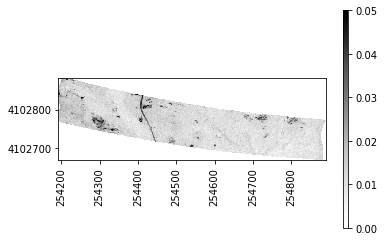

In [11]:
## Plot the cleaned data
plot_aop_refl(data_clean[:,:,0],
              metadata_clean['spatial extent'],
              (0,0.05))

In [15]:
data_clean[~np.isnan(data_clean)]

array([0.0299, 0.0522, 0.0431, ..., 0.0327, 0.0296, 0.0302])

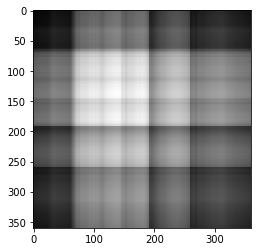

In [21]:
#pc = principal_components(data_clean)
pc = principal_components(data_clean[~np.isnan(data_clean)])
pc_view = imshow(pc.cov)
xdata = pc.transform(data_clean)

In the covariance matrix display, whiter values indicate strong positive covariance, darker values indicate strong negative covariance, and grey values indicate covariance near zero.

To reduce dimensionality using principal components, we can sort the eigenvalues in descending order and then retain enough eigenvalues (an corresponding eigenvectors) to capture a desired fraction of the total image variance. We then reduce the dimensionality of the image pixels by projecting them onto the remaining eigenvectors. We will choose to retain a minimum of 99.9% of the total image variance.

In [26]:
pcdata = pc.reduce(num=10).transform(data_clean)

pc_0999 = pc.reduce(fraction=0.9999)

# How many eigenvalues are left?
print(len(pc_0999.eigenvalues))

#img_pc = pc_0999.transform(data_clean)
print(img_pc.shape)

#v = imshow(img_pc[:,:,:5], stretch_all=True)

2
(216, 699, 2)


 Export PCA values to a geotiff raster to be used in classification analysis

In [ ]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()